In [1]:
import pandas as pd
import numpy as np
import random
import re
import csv
from collections import defaultdict
from gensim import corpora, models, similarities, matutils
from string import punctuation
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import nltk
from nltk import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

In [2]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\susan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#pd.set_option('display.max_colwidth', -1)

In [6]:
summary = pd.read_csv('../data/dreamers_summary.csv', sep='|')
print(summary.shape)

(89, 8)


In [151]:
summary

,group,dreamer sex,dreamer age,dream years,numbers of dreams,summary,id,total_words
0,Alta: a detailed dreamer,female,adult,1985-1997,422,Alta is an adult woman who wrote down her drea...,1,166351.0
1,Angie: age 18 & 20,female,18 to 20,1996,48,Angie is a college student whose dreams are of...,2,9754.0
2,Arlie: a middle-aged woman,female,middle-aged,1992-1998,212,Arlie is an older adult woman who wrote down h...,3,22022.0
3,Barb Sanders,female,20 to 60,1960-1997,3116,Barb Sanders (not her real name) is a middle-a...,4,576351.0
4,Barb Sanders #2,female,60 to 64,1997-2001,1138,"1138 more dreams from Barb Sanders, written do...",5,217901.0
5,Barb Sanders: baseline,female,20 to 60,1960-1999,250,These 250 dreams are a representative sample o...,6,38588.0
6,Bay Area girls: Grades 4-6,female,9 to 11,1996-1997,234,The 388 dreams in this set were collected in N...,7,27521.0
7,Bay Area girls: Grades 7-9,female,12 to 14,1996-1997,154,The 388 dreams in this set were collected in N...,8,21712.0
8,Bea 1: a high school student,female,14 to 16,2003-2005,223,Bea's vivid dream reports from age 14 to 16 pr...,9,28698.0
9,Bea 2: a college student,female,14 to 16,2007-2010,63,See Bea 1.,10,14128.0


In [7]:
dream = pd.read_csv('../data/dreams_clean.csv', sep=';')
print(dream.shape)
# Borro aquellos sueños que no tienen palabras y aquellos en aleman que son los del grupo con id 18, 26 y 27
dream = dream.dropna(axis=0, subset=['words']).drop(dream.loc[dream['group_id'].isin([18, 26, 27, 79, 80])].index)
print(dream.shape)


(43226, 5)
(36202, 5)


In [8]:
df = pd.merge(dream, summary, left_on='group_id', right_on='id')
print(df.shape)


(36202, 13)


In [9]:
df.head()

,code,note,description,words,group_id,group,dreamer sex,dreamer age,dream years,numbers of dreams,summary,id,total_words
0,1,1957,"The one at the Meads's house, where it's bigge...",154.0,1,Alta: a detailed dreamer,female,adult,1985-1997,422,Alta is an adult woman who wrote down her drea...,1,166351.0
1,2,8/11/67,I'm at a family reunion in a large fine house ...,248.0,1,Alta: a detailed dreamer,female,adult,1985-1997,422,Alta is an adult woman who wrote down her drea...,1,166351.0
2,3,8/1/85,I watch a plane fly past and shortly realize i...,303.0,1,Alta: a detailed dreamer,female,adult,1985-1997,422,Alta is an adult woman who wrote down her drea...,1,166351.0
3,4,1985?,Me pulling the green leaves and berries off so...,468.0,1,Alta: a detailed dreamer,female,adult,1985-1997,422,Alta is an adult woman who wrote down her drea...,1,166351.0
4,5,1985?,I'm in a room that reminds me of (but definite...,561.0,1,Alta: a detailed dreamer,female,adult,1985-1997,422,Alta is an adult woman who wrote down her drea...,1,166351.0


In [10]:
df_vietnam = df.loc[df['group'].isin(['Vietnam Vet: 1970-2008 war dreams', 'Vietnam Vet: 2015 dreams', 'Vietnam Vet: 2016-17 dreams'])]
df_phil = df.loc[df['group'].isin(['Phil 1: teens', 'Phil 2: late 20s', 'Phil 3: retirement'])]

print(f"Se cuenta con {len(df_vietnam)} sueños de Vietnam. El corpus tiene {int(df_vietnam['words'].sum())} palabras.")
print(f"Se cuenta con {len(df_phil)} sueños de Phil, nuestro conjunto de control. El corpus tiene {int(df_phil['words'].sum())} palabras.")


Se cuenta con 593 sueños de Vietnam. El corpus tiene 80684 palabras.
Se cuenta con 506 sueños de Phil, nuestro conjunto de control. El corpus tiene 85162 palabras.


In [11]:
stoplist = stopwords.words('english')
def tokenize(one_document, stop_words=stopwords.words('english')):
    one_document = one_document.lower()
    return [
        word for word in word_tokenize(one_document) if word not in stoplist
        and word.isalpha() and len(word) > 1
        ]

texts = [tokenize(a_doc, stoplist) for a_doc in df['description']]

In [12]:
print("el corpus tiene",len(texts), "oraciones y",sum([len(x) for x in texts]),"palabras"   )

el corpus tiene 36202 oraciones y 2605429 palabras


In [13]:
collocations = Phrases(sentences=texts, min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado

In [14]:
to_collocations = Phraser(collocations)

In [15]:
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(texts)],columns=["bigram","score"])
df_collocations.shape

(53422, 2)

In [16]:
df_collocations.drop_duplicates().sort_values(by="score",ascending=False).head(25)

,bigram,score
19558,b'alain delon',1.000000
17708,b'battlestar galactica',1.000000
18296,b'der beek',0.997489
46139,b'tae kwon',0.993486
7040,b'ping pong',0.993486
1040,b'clint eastwood',0.992357
2890,b'los angeles',0.991539
16757,b'freaks geeks',0.989074
14767,b'monty python',0.988196
13351,b'notre dame',0.985380


In [17]:
texts_ngrams = to_collocations[texts]

In [18]:
print("el corpus tiene",len(texts_ngrams), "oraciones y",sum([len(x) for x in texts_ngrams]),"palabras"   )

el corpus tiene 36202 oraciones y 2552007 palabras


## WordEmbedding Word2Vec

In [19]:
# "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
# "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
# "workers" es el numero de cores que usa en paralelo. Para aprobechar eso es necesario tener instalado Cython)
# "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
# "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
# "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
# para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html

w2v_model = Word2Vec(texts_ngrams, workers=4,size=20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)


In [153]:
#w2v_model.most_similar(positive=["danger"], negative=[], topn=25)

[('flee', 0.9480360150337219),
 ('destruction', 0.9146144986152649),
 ('rescue', 0.8962359428405762),
 ('fearful', 0.8947770595550537),
 ('surrender', 0.8906325101852417),
 ('escapes', 0.8825399875640869),
 ('dangerous', 0.8811810612678528),
 ('crooks', 0.875928521156311),
 ('abandon', 0.8695865869522095),
 ('fearing', 0.8693142533302307),
 ('escape', 0.8684341907501221),
 ('ambush', 0.8567867279052734),
 ('attackers', 0.8539775609970093),
 ('pursuing', 0.8505699634552002),
 ('warn', 0.8488671779632568),
 ('sweeps', 0.8487762212753296),
 ('deaths', 0.8475284576416016),
 ('command', 0.8468292951583862),
 ('tornados', 0.8458808660507202),
 ('forcing', 0.8450484275817871),
 ('terrified', 0.8431124091148376),
 ('orbit', 0.8404114246368408),
 ('rescued', 0.8395755887031555),
 ('invaded', 0.8384202718734741),
 ('deadly', 0.8382383584976196)]

In [161]:
w2v_model.wv.n_similarity(["disappointed"], ["frustration"])

0.5969934

In [22]:
#w2v_model.wv.n_similarity(["war"], ["love"])

In [23]:
#w2v_model.wv.n_similarity(["love"], ["peace"])

In [24]:
#w2v_model.wv.n_similarity(["war"], ["peace"])

In [25]:
#target_word="war"
#places = ["vietnam","london","england","united_states","mexico","france","japan","russia","cambodia","ireland","turkey"]
#fun_score = []
#for place in places:
#    fun_score.append(w2v_model.wv.n_similarity([target_word], [place]))
    
#pd.DataFrame(fun_score,index = places,columns=[target_word]).sort_values(by=target_word).plot(kind="bar",figsize=(15,5), fontsize=20)

## Document Vector : Vectores de los sueños

In [48]:
# array con los WE de las palabras de un sueño
def hacer_array_de_WEs(one_dream):
    return [
      w2v_model.wv[word] for word in  texts_ngrams[one_dream]  if word in w2v_model.wv.vocab    
       ]


In [49]:
def hacer_vectores_dreams(lista_series):
    # lista_series: si quiero sobre todas las series , paso lista_series como una lista vacia 
    vectores_wes = [hacer_array_de_WEs(d) for d in list(range(len(df['description']))) if df['group'][d] in list(lista_series) or len(lista_series)==0]
    vectores_dreams = [ np.mean(np.array(vectores_wes[d]), axis = 0) for d in list(range(len(vectores_wes)))]
    return vectores_dreams

In [50]:
# Armo una matriz de distancias en base a similaridad coseno
def matriz_distancias(p_wes_dreams):
    distancias=np.zeros((len(p_wes_dreams),len(p_wes_dreams))) #matriz cuadrada
    for i,ti in enumerate(p_wes_dreams):
        for j,tj in enumerate(p_wes_dreams):
            distancias[i,j] = abs(1- w2v_model.wv.cosine_similarities(p_wes_dreams[i],p_wes_dreams[j:j+1])[0] )
    print (distancias.shape)
    return distancias

## sobre todos los sueños

In [51]:
#vectores_wes = [hacer_array_de_WEs(d) for d in list(range(len(df['description'])))]
#wes_dreams = [ np.mean(np.array(vectores_wes[d]), axis = 0) for d in list(range(len(vectores_wes)))]

lista_dreams=[]  #lista  vacia indica todas las series
wes_dreams = hacer_vectores_dreams(lista_dreams)


In [52]:
# Vectores de los 4 primeros sueños
print(np.array(wes_dreams[:4]))

[[ 4.2869619e-01  3.9955139e-01 -4.4405185e-02  2.9486677e-01
  -1.5125890e-01  1.7225091e-01 -2.9705572e-01 -6.6651180e-02
   1.6579865e-01  3.4635782e-02  2.9808336e-01 -2.6160473e-01
  -2.8825931e-02 -3.9018595e-01  3.3818707e-01 -4.9765953e-01
  -6.8795756e-02 -2.9260826e-01  3.3227590e-01 -4.0198880e-01]
 [ 3.1727195e-01  3.9451340e-01  2.5336521e-03  2.7202511e-01
  -9.1605417e-02  2.7016792e-01 -3.8206875e-01 -1.4943090e-01
   7.4852191e-02 -7.7541652e-03  4.1946530e-01 -1.6040704e-01
  -1.8501431e-01 -3.9462513e-01  1.5817209e-01 -4.4422081e-01
  -2.2432458e-01 -4.6129635e-01  3.5031226e-01 -4.0370357e-01]
 [ 3.4961763e-01  4.3274724e-01  2.4238154e-02  2.5980979e-01
  -1.0934369e-01  1.8279642e-01 -3.8531741e-01 -4.6164859e-02
   1.5982158e-01 -1.3520905e-01  3.8478628e-01 -2.8320420e-01
  -1.5118860e-01 -2.4754375e-01  3.0890268e-01 -4.1138992e-01
  -1.9090241e-01 -2.1187702e-01  3.7731370e-01 -2.0534758e-01]
 [ 4.4993612e-01  3.7086263e-01 -3.7642839e-04  2.6107147e-01
  -1.

In [53]:
len(wes_dreams)

36202

In [54]:
# similaridad de un sueño con otros (los 200 que le siguen)
w1=wes_dreams[1]
vector_similaridades=w2v_model.wv.cosine_similarities(w1,wes_dreams[:200])
#print(vector_similaridades)
print ("sueños similarity min y max:",min(vector_similaridades), max(vector_similaridades))

sueños similarity min y max: 0.8055941 1.0000001


In [55]:
# distancias de 10 sueños entre sí
pd.DataFrame(data=matriz_distancias(wes_dreams[:10]))

(10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.192093e-07,5.560577e-02,5.190963e-02,0.036949,0.055503,3.571498e-02,0.108982,1.034130e-01,0.058335,0.115197
1,5.560571e-02,1.192093e-07,6.211573e-02,0.062750,0.063564,4.291832e-02,0.074439,9.560835e-02,0.083907,0.132220
2,5.190945e-02,6.211555e-02,5.960464e-08,0.024301,0.024760,2.602810e-02,0.031151,5.206341e-02,0.022575,0.091816
3,3.694904e-02,6.274968e-02,2.430135e-02,0.000000,0.023705,1.437777e-02,0.043474,5.780095e-02,0.032650,0.078490
4,5.550331e-02,6.356400e-02,2.476019e-02,0.023704,0.000000,1.752400e-02,0.039623,8.000296e-02,0.014793,0.050811
5,3.571492e-02,4.291832e-02,2.602816e-02,0.014378,0.017524,1.192093e-07,0.039517,7.761043e-02,0.028636,0.058786
6,1.089817e-01,7.443953e-02,3.115124e-02,0.043474,0.039623,3.951687e-02,0.000000,5.636942e-02,0.049902,0.108076
7,1.034127e-01,9.560829e-02,5.206341e-02,0.057801,0.080003,7.761025e-02,0.056369,5.960464e-08,0.095676,0.177209
8,5.833447e-02,8.390737e-02,2.257532e-02,0.032650,0.014793,2.863640e-02,0.049902,9.567559e-02,0.000000,0.068940
9,1.151968e-01,1.322204e-01,9.181625e-02,0.078490,0.050811,5.878574e-02,0.108076,1.772089e-01,0.068940,0.000000


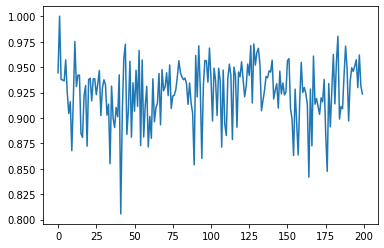

In [56]:
plt.plot(list(range(200)), vector_similaridades)

## sobre Vet serie 1

In [57]:

Vet_wes_dreams_s1 = hacer_vectores_dreams(['Vietnam Vet: 1970-2008 war dreams'])

In [58]:
print(len(Vet_wes_dreams_s1))

98


In [59]:
# similaridad de un sueño con los demás de la serie
w1=Vet_wes_dreams_s1[0]
vector_similaridades=w2v_model.wv.cosine_similarities(w1,Vet_wes_dreams_s1[:98])
print(vector_similaridades)
print ("sueños similarity:",min(vector_similaridades), max(vector_similaridades))

[1.0000001  0.947423   0.94226325 0.95948905 0.9211328  0.9170223
 0.95666856 0.9730472  0.9780372  0.9360961  0.97828466 0.9311917
 0.9662992  0.94987905 0.9304734  0.9036558  0.9298172  0.9252569
 0.8962181  0.9498394  0.96207213 0.9616503  0.95660603 0.9705531
 0.9329829  0.95746946 0.9402967  0.9144811  0.91982234 0.96509343
 0.97034335 0.9630914  0.90563744 0.9613509  0.947789   0.92517936
 0.92887855 0.90309304 0.86400557 0.93199885 0.8328248  0.8898359
 0.94451207 0.9513778  0.9275882  0.9502953  0.90712523 0.92681086
 0.9302794  0.9512087  0.93953645 0.93450594 0.8833126  0.87201124
 0.9126896  0.9447299  0.9455412  0.9506459  0.91023636 0.9213097
 0.9484942  0.9181718  0.9389111  0.9463207  0.93487453 0.8838096
 0.94547915 0.92851865 0.9274393  0.8589543  0.82173485 0.9510828
 0.8670201  0.78024465 0.9561627  0.89773583 0.9470576  0.8635588
 0.903008   0.9492552  0.9435241  0.86872846 0.91410106 0.92725366
 0.884709   0.9447701  0.9391909  0.84337014 0.9240947  0.9413476
 0.91

In [60]:
df_s = pd.DataFrame(data=vector_similaridades,columns=['similaridad'])
df_s.sort_values('similaridad')

,similaridad
73,0.780245
70,0.821735
40,0.832825
87,0.843370
69,0.858954
77,0.863559
38,0.864006
72,0.867020
81,0.868728
53,0.872011


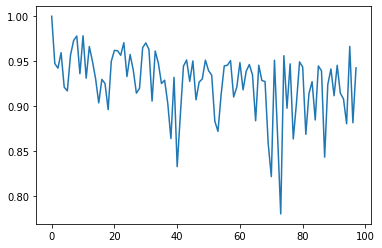

In [61]:
plt.plot(list(range(98)), vector_similaridades)

In [62]:
# ahora veo que pasa con el sueño 73 que dió mas diferente del primer sueño
w1=Vet_wes_dreams_s1[73]
vector_similaridades=w2v_model.wv.cosine_similarities(w1,Vet_wes_dreams_s1[:98])
print(vector_similaridades)
print ("sueños similarity:",min(vector_similaridades), max(vector_similaridades))

[0.78024465 0.7919707  0.8777818  0.853513   0.76864386 0.90354395
 0.79882526 0.8575781  0.8016817  0.87559193 0.81616724 0.8639741
 0.82071    0.8679109  0.8127278  0.91448665 0.8655193  0.7406393
 0.7892162  0.8552864  0.827331   0.7432804  0.84278595 0.8463108
 0.78884804 0.8511311  0.8501697  0.74447554 0.91184556 0.80830353
 0.83775306 0.8065182  0.8852393  0.80621713 0.8360106  0.8665642
 0.8381879  0.7829323  0.8643484  0.83059216 0.83678865 0.7890879
 0.88503724 0.84905076 0.7395425  0.8094103  0.64572674 0.77824014
 0.8513711  0.8130297  0.74478215 0.7886963  0.82653016 0.7461522
 0.89761645 0.8206889  0.82841635 0.835009   0.91070324 0.8652108
 0.86244434 0.82345915 0.7904769  0.80541325 0.739289   0.91525507
 0.80752563 0.9179639  0.83590263 0.7411113  0.8692166  0.8660684
 0.81627655 1.0000001  0.85507935 0.8744008  0.80938125 0.75860804
 0.8412822  0.79238695 0.87221634 0.79587966 0.89442366 0.8677816
 0.77177066 0.8208608  0.80883646 0.86427736 0.8657368  0.8027949
 0.85

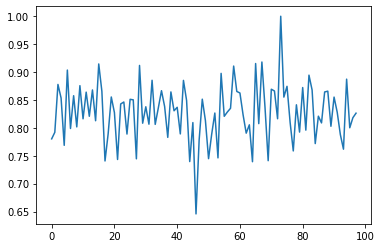

In [63]:
plt.plot(list(range(98)), vector_similaridades)

## Clustering sobre los vectores de los sueños 

## Clustering jerarquico

In [65]:
# Definicion Funcion de hopkins para evaluar tendencia al clustering
def Hopkins(df,*args):
    n = df.shape[0] # filas
    d = df.shape[1] # columnas
    if not args:
        print("Numero de puntos al azar por defecto")
        m = int(0.1 * n) # cantidad de puntos al azar (default)
    else:
        m = args[0] # cantidad de puntos al azar

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df) # buscador de vecinos

    rand_ind = random.sample(range(0, n, 1), m) # indices al azar

    ui = []
    wi = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
        ui.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
        wi.append(w_dist[0][1])

    H = sum(wi) / (sum(ui) + sum(wi))
    return H

In [91]:
def ClusterJerarq(p_datos, p, p_lista_dreams):
    n = len(p_datos)
    print('cantidad de sueños =',n)
    print('Tendencia al clustering Hopkins: ',Hopkins(pd.DataFrame.from_records(p_datos).values))
    
    m_dist=matriz_distancias(p_datos)
    
    l = linkage(m_dist, method='average', metric='cosine')

    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    #plt.figure()
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('distance')
    plt.xlabel('dreams')

    den=dendrogram(
        l,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        orientation='top',
        truncate_mode='lastp',  # show only the last p merged clusters
        p=50,  # show only the last p merged clusters
        show_leaf_counts=True,  # otherwise numbers in brackets are counts
        show_contracted=True,  # to get a distribution impression in truncated branches
    )

    ax = plt.gca()
    bounds = ax.get_xbound()
    ax.plot(bounds, [p, p], '--', c='k')
    plt.show()
    
    c, coph_dists = cophenet(l, pdist(p_datos))
    print('Coeficiente Cofenetico :  ',c)
    
    #clusters de sueños, depende a donde corto el dendograma, con p
    f=fcluster(l, p, 'distance')
    
    return f

In [256]:
def grafico_clusters_dreams(p_clusters, p_lista_dreams, p_colors):
    n = len(p_clusters)
    plt.figure(figsize=(18,6))
    plt.scatter(list(range(n)), p_clusters,c=p_colors)
    plt.xlabel('Dream #')
    plt.ylabel('Cluster #');
    
    
    #grafico los sueños en los clusters, marco donde empieza cada serie
    ax = plt.gca()
    bounds = ax.get_ybound()
    pos_x=0
    for grupo in p_lista_dreams:
        print(grupo)
        pos_x=pos_x+summary[summary['group']==grupo]["numbers of dreams"].values[0]
        print(pos_x)
        ax.plot([pos_x, pos_x],bounds, '--', c='k')
    plt.show()
    

    

In [257]:
def grafico_histograma_clusters(p_clusters, p_lista_dreams):
   # n = len(p_clusters)
    
      
    #histogramas
    if len(p_lista_dreams)>0:
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        pos_i=0
        pos_f=0
        i=0
        for axis in axes :
                grupo=p_lista_dreams[i]
                print(grupo)
                n=summary[summary['group']==grupo]["numbers of dreams"].values[0]
                pos_f=pos_i + n - 1
                #print(pos_i, pos_f, n)
                data = {grupo:p_clusters[pos_i:pos_f]}
                pd.DataFrame(data).hist(ax=axis)
                pos_i=pos_i + n
                i= i + 1


    

In [258]:
# Para las listas de colores segun las emociones
col         = 'Sentimiento'
choices     = [ "green", 'black', 'pink','blue','red','yellow', 'brown','lightblue']
Vet_conditions  = [ Vet_dominant_emot[col] =="Trust",Vet_dominant_emot[col] =="Fear",Vet_dominant_emot[col] =="Joy",
               Vet_dominant_emot[col] =="Sadness", Vet_dominant_emot[col] =="Anger",Vet_dominant_emot[col] =="Anticipation",
              Vet_dominant_emot[col] =="Disgust",Vet_dominant_emot[col] =="Surprise"]
Phil_conditions  = [ Phil_dominant_emot[col] =="Trust",Phil_dominant_emot[col] =="Fear",Phil_dominant_emot[col] =="Joy",
               Phil_dominant_emot[col] =="Sadness", Phil_dominant_emot[col] =="Anger",Phil_dominant_emot[col] =="Anticipation",
              Phil_dominant_emot[col] =="Disgust",Phil_dominant_emot[col] =="Surprise"]

In [259]:
# Leo SA para Vet 
# Positivos y Negativos
Vet_dominant_sent = pd.read_csv('../data/sa/vet_dominant_sent.txt', header=None ,names=['Sentimiento'])
print(Vet_dominant_sent.iloc[:,-1].value_counts())
Vet_dominant_sent['color']= np.where( Vet_dominant_sent["Sentimiento"]=="Negative" , "#9b59b6", "#3498db")
Vet_dominant_sent_colors=list(Vet_dominant_sent['color'])
# Emociones
Vet_dominant_emot = pd.read_csv('../data/sa/vet_dominant_emot.txt', header=None ,names=['Sentimiento'])
print(Vet_dominant_emot.iloc[:,-1].value_counts())
Vet_dominant_emot['color']= np.select( Vet_conditions, choices)
Vet_dominant_emot_colors=list(Vet_dominant_emot['color'])


Negative    403
Positive    190
Name: Sentimiento, dtype: int64
Fear            171
Trust           159
Joy              87
Sadness          87
Anger            47
Anticipation     28
Disgust          14
Name: Sentimiento, dtype: int64


In [260]:
# Leo SA para  PHil

# Positivos y Negativos
Phil_dominant_sent = pd.read_csv('../data/sa/phil_dominant_sent.txt', header=None ,names=['Sentimiento'])
print(Phil_dominant_sent.iloc[:,-1].value_counts())
Phil_dominant_sent['color']= np.where(Phil_dominant_sent["Sentimiento"]=="Negative" , "#9b59b6", "#3498db")
Phil_dominant_sent_colors=list(Phil_dominant_sent['color'])

# Emociones
Phil_dominant_emot = pd.read_csv('../data/sa/phil_dominant_emot.txt', header=None ,names=['Sentimiento'])
print(Phil_dominant_emot.iloc[:,-1].value_counts())
Phil_dominant_emot['color']= np.select( Phil_conditions, choices)
Phil_dominant_emot_colors=list(Phil_dominant_emot['color'])

Positive    264
Negative    242
Name: Sentimiento, dtype: int64
Trust           214
Joy              73
Anger            61
Anticipation     55
Fear             49
Sadness          43
Disgust           9
Surprise          2
Name: Sentimiento, dtype: int64


## Sobre Vet completo

cantidad de sueños = 593
Numero de puntos al azar por defecto
Tendencia al clustering Hopkins:  0.061712616156905514
(593, 593)


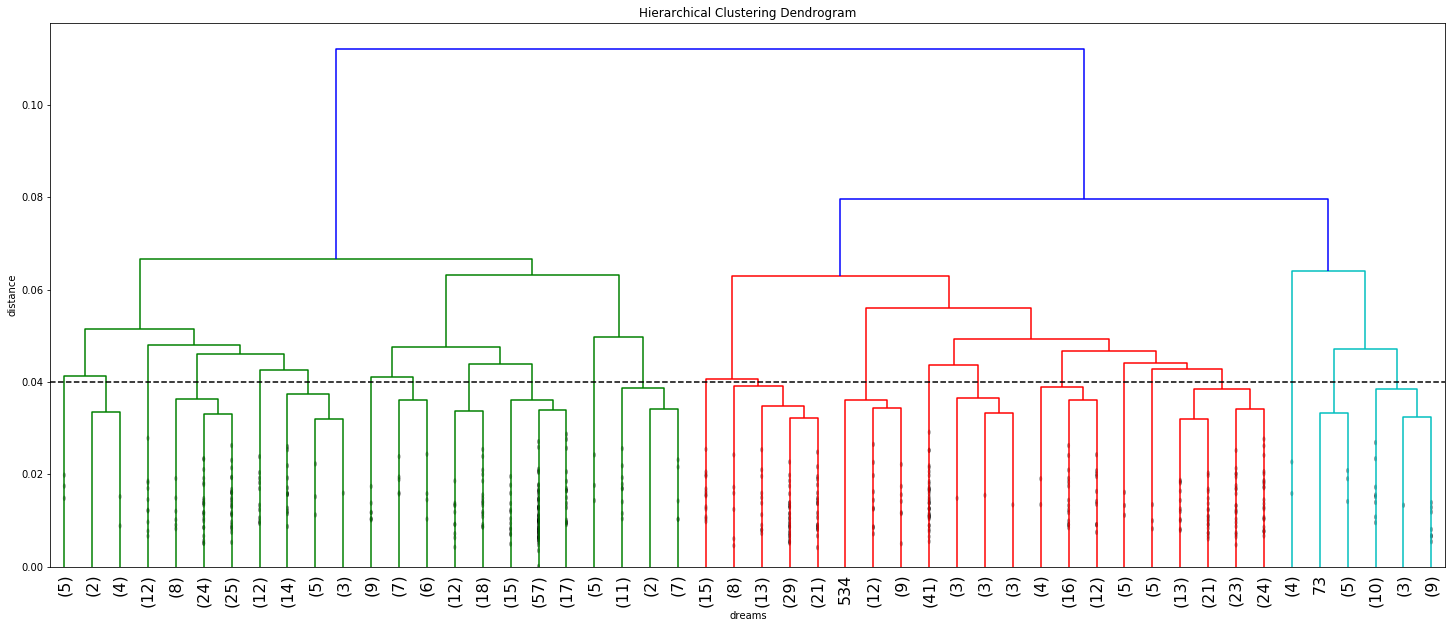

Coeficiente Cofenetico :   0.3428594414608417


In [261]:
Vet_lista_dreams=['Vietnam Vet: 1970-2008 war dreams', 'Vietnam Vet: 2015 dreams', 'Vietnam Vet: 2016-17 dreams']
Vet_wes_dreams = hacer_vectores_dreams(Vet_lista_dreams)
Vet_dreams_clusters_jerarq=ClusterJerarq(Vet_wes_dreams,0.04,Vet_lista_dreams)

Vietnam Vet: 1970-2008 war dreams
98
Vietnam Vet: 2015 dreams
130
Vietnam Vet: 2016-17 dreams
593


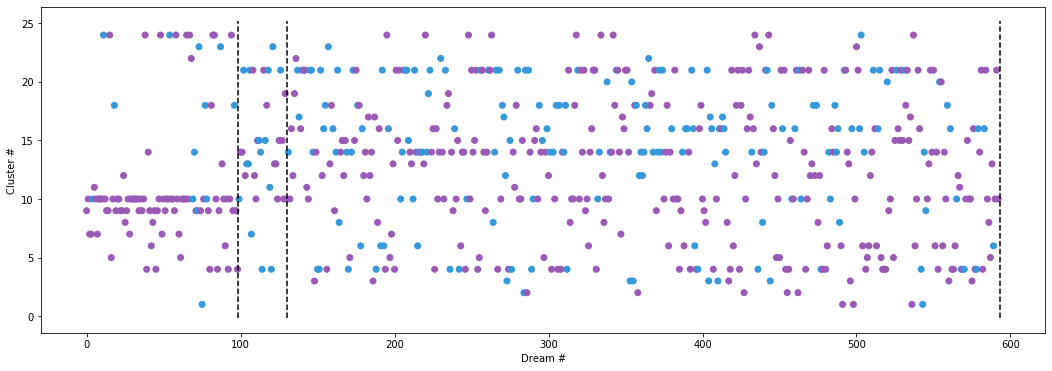

Vietnam Vet: 1970-2008 war dreams
98
Vietnam Vet: 2015 dreams
130
Vietnam Vet: 2016-17 dreams
593


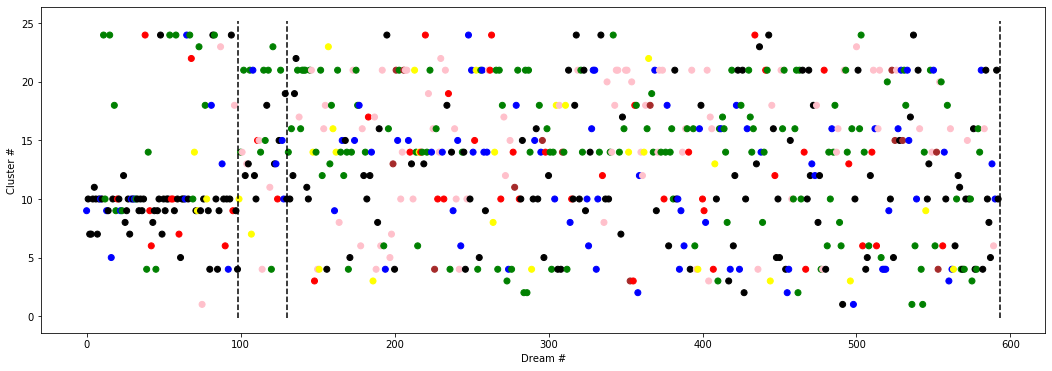

Vietnam Vet: 1970-2008 war dreams
Vietnam Vet: 2015 dreams
Vietnam Vet: 2016-17 dreams


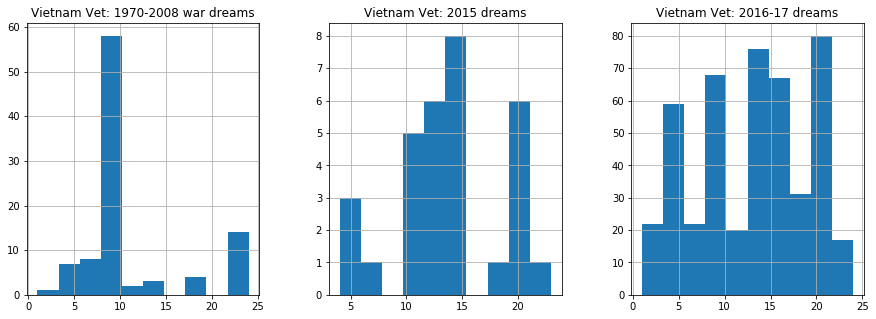

In [262]:
grafico_clusters_dreams(Vet_dreams_clusters_jerarq,Vet_lista_dreams,Vet_dominant_sent_colors)
grafico_clusters_dreams(Vet_dreams_clusters_jerarq,Vet_lista_dreams,Vet_dominant_emot_colors)
grafico_histograma_clusters(Vet_dreams_clusters_jerarq,Vet_lista_dreams)

## Sobre Phil


cantidad de sueños = 506
Numero de puntos al azar por defecto
Tendencia al clustering Hopkins:  0.06013767329552543
(506, 506)


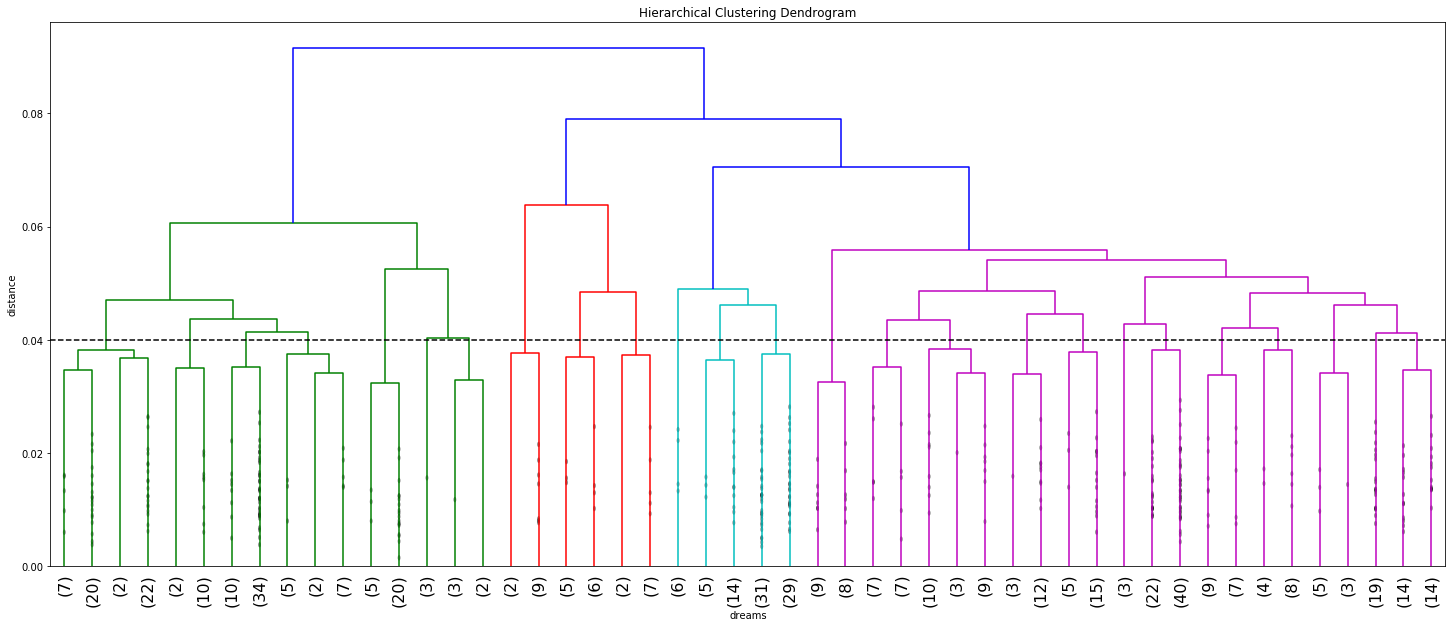

Coeficiente Cofenetico :   0.34342047575053286


In [263]:
Phil_lista_dreams=['Phil 1: teens', 'Phil 2: late 20s', 'Phil 3: retirement']
Phil_wes_dreams = hacer_vectores_dreams(Phil_lista_dreams)
Phil_dreams_clusters_jerarq=ClusterJerarq(Phil_wes_dreams,0.04, Phil_lista_dreams)

Phil 1: teens
106
Phil 2: late 20s
326
Phil 3: retirement
506


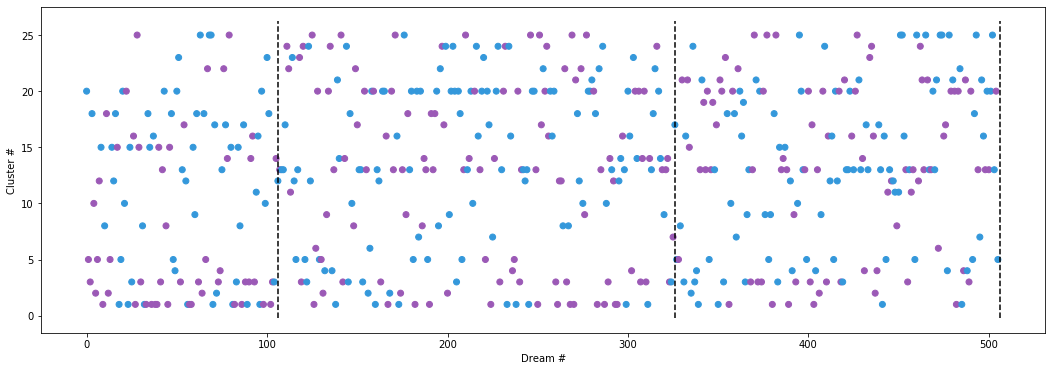

Phil 1: teens
106
Phil 2: late 20s
326
Phil 3: retirement
506


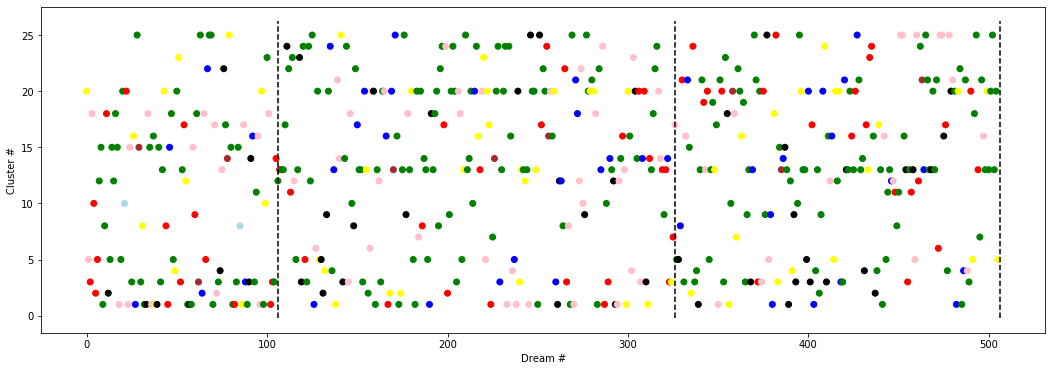

Phil 1: teens
Phil 2: late 20s
Phil 3: retirement


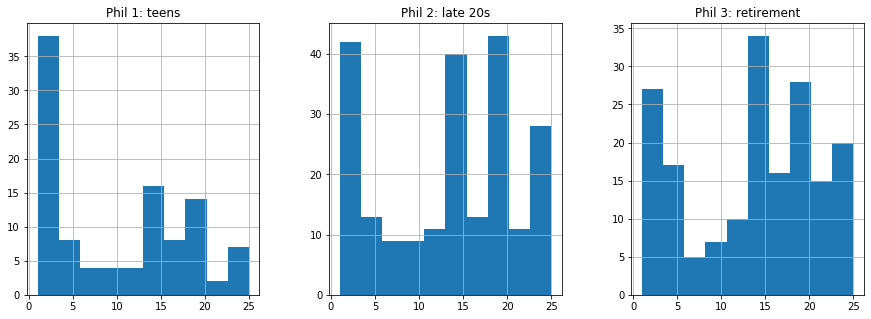

In [264]:
grafico_clusters_dreams(Phil_dreams_clusters_jerarq,Phil_lista_dreams,Phil_dominant_sent_colors)
grafico_clusters_dreams(Phil_dreams_clusters_jerarq,Phil_lista_dreams,Phil_dominant_emot_colors)
grafico_histograma_clusters(Phil_dreams_clusters_jerarq,Phil_lista_dreams)

## sobre todos los sueños

cantidad de sueños = 5000
Numero de puntos al azar por defecto
Tendencia al clustering Hopkins:  0.04792228399156238
(5000, 5000)


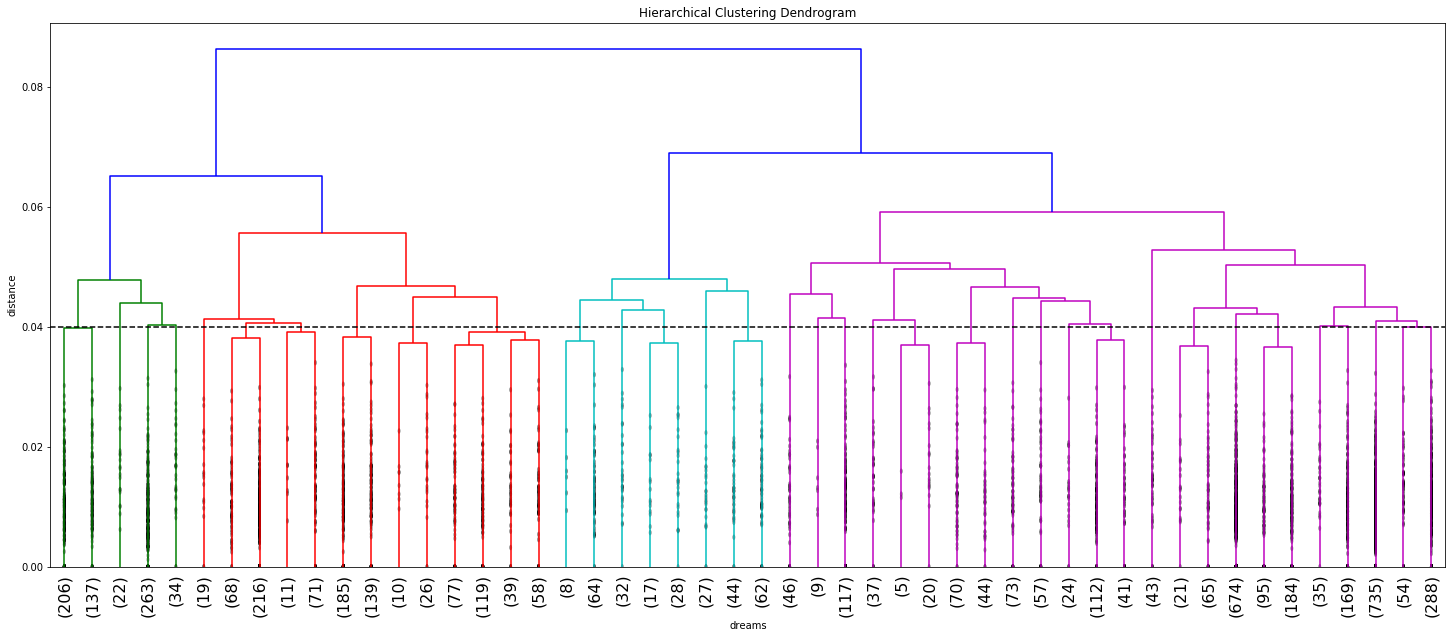

Coeficiente Cofenetico :   0.3773674594668804


In [101]:
#All_dreams_clusters_jerarq=ClusterJerarq(wes_dreams[15000:20000],0.04,[])

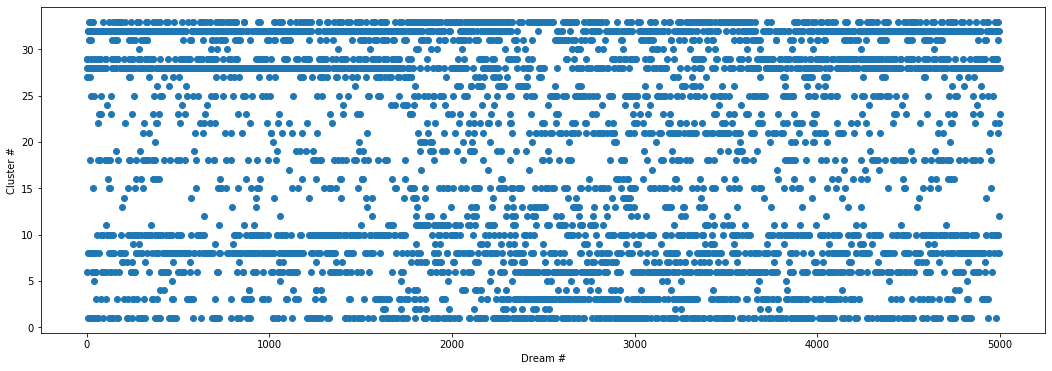

In [150]:
#grafico_clusters_dreams(All_dreams_clusters_jerarq,[]) 